# Plot all radiants of the global meteor network

Tammo Jan Dijkema, 22 November 2023

Goal of this notebook is to make a plot of the radiants of the [Global Meteor Network](https://www.globalmeteornetwork.org/), on the occasion of its one million-th orbit on 6 October 2023.

In [1]:
import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

from datetime import datetime
from glob import glob
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

plt.style.use("dark_background")

Download all monthly data in it, e.g. by running something like
```
wget -r -l 1 -nd -P data https://globalmeteornetwork.org/data/traj_summary_data/monthly/
```

In [2]:
filenames = sorted(glob("data/*.txt"))

In [3]:
df_rms = None
for filename in tqdm(filenames):
    df_one = pd.read_csv(
        filename,
        delimiter=";",
        header=3,
        usecols=[2, 3, 5, 7, 9, 11, 13, 15],
        na_values=["None", "    None"],
        names=[
            "Datestr",
            "Shower",
            "Sol lon",
            "RAgeo",
            "DECgeo",
            "LambdaGeo",
            "BetaGeo",
            "VelGeo",
        ],
    )
    if df_rms is None:
        df_rms = df_one
    else:
        df_rms = pd.concat([df_rms, df_one])

  0%|          | 0/60 [00:00<?, ?it/s]

In [4]:
df = df_rms

In [5]:
def to_range(x):
    """Unwrap x so that it will be between -180 and +180"""
    return (x + 180) % 360 - 180

Compute the rounded values for $\lambda$, $\beta$ here, so we can bin them later on. Also here, we subtract the longitude of the Sun from $\lambda$ to get the Sun-centered variant.

In [6]:
df["RAgeo_int"] = to_range(df["RAgeo"].round())
df["LambdaGeo"] = to_range((df["LambdaGeo"] - df["Sol lon"]) % 360)
df["LambdaGeo_int"] = 0.5 * (2 * df["LambdaGeo"]).round()
df["BetaGeo_int"] = 0.25 * (4 * df["BetaGeo"]).round()
df["DECgeo_int"] = 0.5 * (2 * df["DECgeo"]).round()
df["Sol lon int"] = df["Sol lon"].round()
df.loc[df["Sol lon int"] == 360.0, "Sol lon int"] = 0.0

In [7]:
df["Datestr"] = pd.to_datetime(df["Datestr"])

In [8]:
df["Sol lon int unwrap"] = np.unwrap(
    df.sort_values("Datestr")["Sol lon int"].values, period=360
)

In [9]:
df = df.sort_values("Datestr")

Aggregate by rounded $\lambda$, $\beta$, and restrict to the actual first 1000000.

In [10]:
df_grouped = (
    df.iloc[:1000000].groupby(["LambdaGeo_int", "BetaGeo_int"])
    .count()
    .reset_index()
    .sort_values("Sol lon")
)[["LambdaGeo_int", "BetaGeo_int", "Sol lon"]]

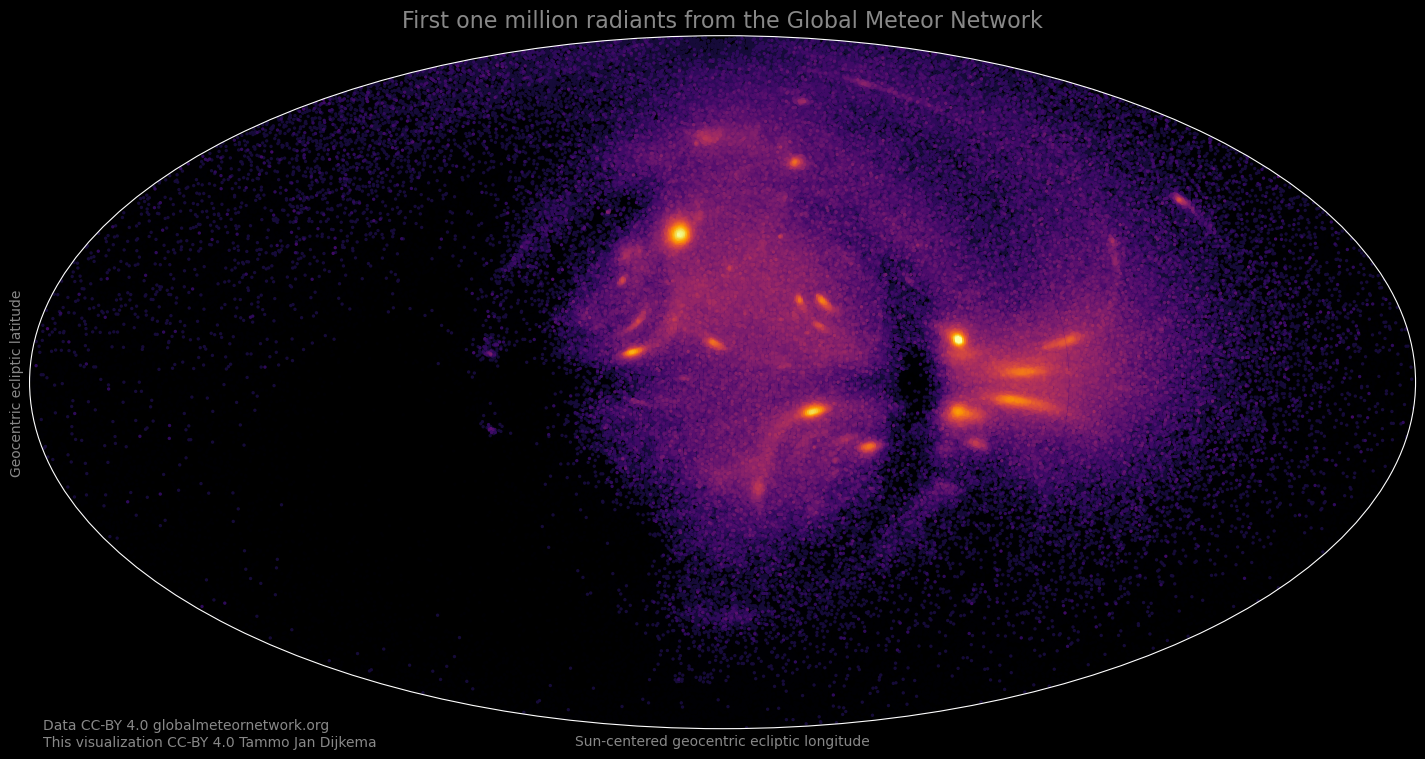

In [12]:
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111, projection="aitoff")
im = ax.scatter(
    [-np.deg2rad(to_range(df_grouped["LambdaGeo_int"] + 90))],
    [np.deg2rad(df_grouped["BetaGeo_int"])],
    s=2,  # Tweak to fill image but not overlap (this is impossible due to the projection)
    c=np.log(df_grouped["Sol lon"]),
    vmin=0,
    vmax=7,
    cmap="inferno",
)
ax.set_xticklabels([f"{(np.rad2deg(pos) - 90)%360:.0f}˚" for pos in ax.get_xticks()])
ax.set_axisbelow(True)
ax.grid(which="major", linewidth=0.4, color="#888")
ax.tick_params(axis="x", colors="#666", labelsize=8)
ax.tick_params(axis="y", colors="#666", labelsize=8)
ax.set_xlabel("Sun-centered geocentric ecliptic longitude", color="#888")
ax.set_ylabel("Geocentric ecliptic latitude", color="#888")
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"{len(df)} meteor radiants", color="#888")
ax.text(
    0.01,
    -0.025,
    "Data CC-BY 4.0 globalmeteornetwork.org\nThis visualization CC-BY 4.0 Tammo Jan Dijkema",
    transform=ax.transAxes,
    color="#888",
)
ax.set_title("First one million radiants from the Global Meteor Network", fontsize=16)
fig.savefig(f"rms_million.png", bbox_inches="tight");

Bonus: we can read all [CAMS v3 data](http://cams.seti.org/CAMS-v3-2010to2016.xlsx) into the same dataframe to get about 0.5 million more orbits. Reading this file takes about three minutes on my computer.

In [ ]:
start_time = time()
# Takes 3.5 minutes
df_cams = pd.read_excel(
    "CAMS-v3-2010to2016.xlsx",
    header=0,
    skiprows=[0, 1, 2, 4],
    usecols=[
        "Date",
        "Shower I.D.",
        "Solar Longitude",
        "R.A. Geocentric",
        "Decl. Geocentric",
        "Lambda Geocentric",
        "Beta Geocentric",
        "V Geocentric",
    ],
)
end_time = time()

In [7]:
rename_colnames = dict(
    zip(
        sorted(list(df_cams.columns), key=str.casefold),
        sorted(list(df_rms.columns), key=str.casefold),
    )
)

In [ ]:
df = pd.concat([df_rms, df_cams])